# Masked Autoencoders

[Paper here](https://arxiv.org/pdf/2111.06377)


In [1]:
# %cd "Deep-Learning-From-Scratch/Transformers/MAE/"

In [2]:
from rich import print
from tqdm.notebook import tqdm

%load_ext rich

In [26]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
from torchvision.utils import make_grid
# import wandb
import einops
from einops.layers.torch import Rearrange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# wandb.require('core')
# wandb.login()

In [170]:
# Hyperparameters
NUM_CLASSES = 10
PATCH_SIZE = 4
NUM_BLOCKS = 12
DIM_EMBEDDING = 384
DIM_HIDDEN = DIM_EMBEDDING * 4
NUM_HEADS = 6
DROPOUT_RATE = 0.1
IMAGE_SHAPE = (3, 32, 32)
DECODER_DIM_EMEDDING = 384
DECODER_DIM_HIDDEN = DECODER_DIM_EMEDDING * 4
DECODER_NUM_BLOCKS = 4

BATCH_SIZE = 128
N_EPOCHS = 50
LEARNING_RATE = 1.5e-4
WEIGHT_DECAY = 5e-2

## Load the dataset


In [11]:
true_labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [12]:
train_dataset = CIFAR10(
    root="./data/", download=True, train=True, transform=v2.ToImage()
)
test_dataset = CIFAR10(
    root="./data/", download=True, train=False, transform=v2.ToImage()
)


100%|██████████| 170498071/170498071 [00:02<00:00, 60062790.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


In [14]:
mean_pixel_train = train_dataset.data.mean(axis=(0, 1, 2)) / 255
std_pixel_train = train_dataset.data.std(axis=(0, 1, 2)) / 255

mean_pixel_test = test_dataset.data.mean(axis=(0, 1, 2)) / 255
std_pixel_test = test_dataset.data.std(axis=(0, 1, 2)) / 255

(mean_pixel_train, std_pixel_train), (mean_pixel_test, std_pixel_test)


(
    (array([0.49139968, 0.48215841, 0.44653091]), array([0.24703223, 0.24348513, 0.26158784])),
    (array([0.49421428, 0.48513139, 0.45040909]), array([0.24665252, 0.24289226, 0.26159238]))
)

In [15]:
train_transform = v2.Compose(
    [
        v2.RandomResizedCrop(32),
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
        v2.Normalize(mean_pixel_train, std_pixel_train),
    ]
)

test_transform = v2.Compose(
    [
        v2.Resize(32),
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
        v2.Normalize(mean_pixel_test, std_pixel_test),
    ]
)

In [16]:
def reverse_transform(x, train=True):
    mean_pixel, std_pixel = (
        mean_pixel_train if train else mean_pixel_test,
        std_pixel_train if train else std_pixel_test,
    )

    x = x * torch.tensor(std_pixel, device=x.device).view(3, 1, 1) + torch.tensor(
        mean_pixel, device=x.device
    ).view(3, 1, 1)
    x = v2.ToPILImage()(x)

    return x

In [17]:
full_train_dataset = CIFAR10(
    root="./data/", download=True, train=True, transform=train_transform
)

test_dataset = CIFAR10(
    root="./data/", download=True, train=False, transform=test_transform
)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
# Calculate the sizes for training and validation datasets (70-30 split)
train_size = int(0.7 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Split the full training dataset into training and validation datasets
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])


In [19]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [20]:
len(train_loader), len(val_loader), len(test_loader)

(274, 118, 79)

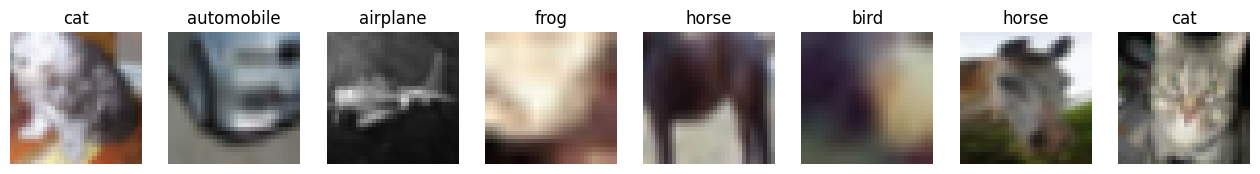

In [21]:
fig, axs = plt.subplots(1, 8, figsize=(16, 2))
indices = torch.randperm(len(train_dataset))[:8]
for i, idx in enumerate(indices):
    img, label = train_dataset[idx]
    img = reverse_transform(img, train=True)
    axs[i].imshow(img)
    axs[i].set_title(f"{true_labels[label]}")
    axs[i].axis("off")

plt.show()

## Build the architecture

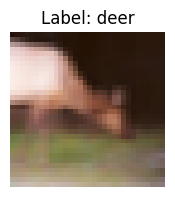

In [23]:
sample_image, sample_target = train_dataset[12]
plt.figure(figsize=(2, 5))
plt.imshow(reverse_transform(sample_image))
plt.title(f"Label: {true_labels[sample_target]}")
plt.axis("off")
plt.show()

In [27]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, d_embd, image_shape, dropout=0.0, debug=False):
        super(PatchEmbedding, self).__init__()

        self.patch_size = patch_size
        self.d_embd = d_embd

        self.n_channels, img_height, img_width = image_shape
        assert (
            img_height % self.patch_size == 0 and img_width % self.patch_size == 0
        ), "Invalid patch size"

        self.n_patches = (img_height // self.patch_size) * (
            img_width // self.patch_size
        )
        self.input_dim = self.n_channels * self.patch_size * self.patch_size

        self.to_patch_embedding = nn.Sequential(
            einops.layers.torch.Rearrange(
                "b c (h p1) (w p2) -> b (h w) (p1 p2 c)",
                p1=self.patch_size,
                p2=self.patch_size,
            ),
            nn.Linear(self.input_dim, self.d_embd),
        )

        # [CLASS] token
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.d_embd))

        # Learnable positional embedding
        self.pos_embedding = nn.Parameter(
            torch.randn(1, self.n_patches + 1, self.d_embd)
        )

        self.dropout = nn.Dropout(dropout)

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[EMBEDDING] Input")

        x = self.to_patch_embedding(x)

        b, n, _ = x.shape

        cls_tokens = einops.repeat(self.cls_token, "() n d -> b n d", b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        self._debug_print(x, "[EMBEDDING] CLS token")

        x += self.pos_embedding[:, : (n + 1)]
        self._debug_print(x, "[EMBEDDING] POS embedding")

        x = self.dropout(x)

        return x

In [28]:
PatchEmbedding(patch_size=4, d_embd=512, image_shape=sample_image.shape, debug=True)(
    sample_image.unsqueeze(0)
)

[EMBEDDING] Input: torch.Size([1, 3, 32, 32])

[EMBEDDING] CLS token: torch.Size([1, 65, 512])

[EMBEDDING] POS embedding: torch.Size([1, 65, 512])


tensor([[[ 6.0788e-01, -1.2296e+00,  1.5113e+00,  ...,  8.1196e-01,
          -1.3046e+00,  2.0963e-01],
         [ 6.8863e-01,  2.6163e-01, -1.3711e+00,  ...,  7.6173e-01,
          -1.0803e-01, -3.2050e-01],
         [ 2.1558e+00, -4.7971e-01,  2.8977e-01,  ...,  1.2085e+00,
          -1.9605e+00, -2.5604e-01],
         ...,
         [ 7.4937e-01, -7.1291e-01, -1.5589e+00,  ..., -1.3473e+00,
           8.2587e-02, -1.3809e+00],
         [-7.0125e-04, -5.2961e-02,  6.4603e-02,  ...,  2.7573e-01,
          -3.8183e-01, -3.7198e-01],
         [-1.6139e+00,  7.4305e-01, -1.3498e-01,  ...,  1.5784e+00,
           9.5755e-01,  8.2363e-02]]], grad_fn=<AddBackward0>)

In [29]:
class FeedForward(nn.Module):
    def __init__(self, d_embd, d_hidden, dropout=0.0, debug=False):
        super(FeedForward, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(d_embd, d_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_embd),
            nn.Dropout(dropout),
        )

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[MLP] Input")
        x = self.net(x)
        self._debug_print(x, "[MLP] Output")

        return x

In [31]:
FeedForward(d_embd=512, d_hidden=2048, debug=True)(torch.randn(1, 65, 512))

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])


tensor([[[ 3.0770e-02, -1.3345e-01, -2.0107e-01,  ...,  1.5985e-01,
           1.4357e-01, -2.9399e-01],
         [-8.7749e-02, -5.9643e-02,  3.0251e-02,  ...,  1.8024e-01,
           2.4358e-01, -1.0877e-01],
         [-2.1377e-01,  9.9093e-02, -3.9561e-01,  ..., -3.8238e-02,
           8.2492e-02, -1.4824e-01],
         ...,
         [-3.3857e-02,  1.6841e-01, -3.0888e-01,  ...,  5.2849e-01,
           6.4018e-02,  1.4709e-04],
         [ 1.1121e-01,  1.5798e-01,  2.3889e-01,  ..., -6.0486e-02,
           1.8614e-01,  7.6846e-02],
         [ 1.8337e-01,  1.6147e-01, -4.2233e-02,  ..., -1.2536e-01,
           1.3243e-01,  1.1974e-01]]], grad_fn=<ViewBackward0>)

In [45]:
class Attention(nn.Module):
    def __init__(self, d_embd, n_heads, dropout=0.0, debug=False):
        super(Attention, self).__init__()

        self.d_embd = d_embd
        self.n_heads = n_heads
        self.d_head = d_embd // n_heads

        self.qkv = nn.Linear(d_embd, 3 * d_embd, bias=False)
        self.projection = nn.Sequential(nn.Linear(d_embd, d_embd), nn.Dropout(dropout))

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[ATTENTION] Input")

        qkv = self.qkv(x).chunk(3, dim=-1)
        q, k, v = map(
            lambda m: einops.rearrange(m, "b n (h d) -> b h n d", h=self.n_heads), qkv
        )

        self._debug_print(q, "[ATTENTION] Q")
        self._debug_print(k, "[ATTENTION] K")
        self._debug_print(v, "[ATTENTION] V")

        score = torch.matmul(q, k.transpose(-1, -2)) * (self.d_head**-0.5)
        self._debug_print(score, "[ATTENTION] Score")

        attn = F.softmax(score, dim=-1)

        out = torch.matmul(attn, v)
        out = einops.rearrange(out, "b h n d -> b n (h d)")
        self._debug_print(out, "[ATTENTION] Reshaped Scores")

        out = self.projection(out)
        self._debug_print(out, "[ATTENTION] Output")

        return out

In [46]:
Attention(d_embd=512, n_heads=8, debug=True)(torch.randn(1, 197, 512))

[ATTENTION] Input: torch.Size([1, 197, 512])

[ATTENTION] Q: torch.Size([1, 8, 197, 64])

[ATTENTION] K: torch.Size([1, 8, 197, 64])

[ATTENTION] V: torch.Size([1, 8, 197, 64])

[ATTENTION] Score: torch.Size([1, 8, 197, 197])

[ATTENTION] Reshaped Scores: torch.Size([1, 197, 512])

[ATTENTION] Output: torch.Size([1, 197, 512])


tensor([[[ 1.6159e-02, -2.3410e-02, -3.8166e-02,  ..., -1.1450e-02,
           4.9905e-02, -3.9209e-02],
         [ 4.1624e-02, -2.6024e-03, -3.4633e-02,  ...,  1.3259e-02,
           3.2468e-02, -4.7911e-02],
         [ 4.4233e-02, -7.3690e-03, -2.6123e-02,  ..., -7.7010e-03,
           5.3453e-02, -1.2324e-02],
         ...,
         [ 3.3609e-02,  9.0380e-04, -4.9925e-03,  ..., -1.3438e-03,
           4.0517e-02, -3.6519e-02],
         [ 3.0970e-02, -6.9479e-05, -3.0993e-02,  ...,  4.4281e-03,
           4.1852e-02, -3.7477e-02],
         [ 3.3814e-02,  5.8651e-04, -3.1615e-02,  ...,  3.8019e-03,
           3.1272e-02, -2.3980e-02]]], grad_fn=<ViewBackward0>)

In [60]:
class Transformer(nn.Module):
    def __init__(self, d_embd, d_hidden, n_heads, n_layers, dropout=0.0, debug=False):
        super(Transformer, self).__init__()

        self.d_embd = d_embd
        self.d_hidden = d_hidden
        self.n_heads = n_heads
        self.n_layers = n_layers

        self.layers = nn.ModuleList([])

        for _ in range(n_layers):
            self.layers.append(
                nn.ModuleList(
                    [
                        nn.LayerNorm(d_embd),
                        Attention(d_embd, n_heads, dropout, debug),
                        nn.LayerNorm(d_embd),
                        FeedForward(d_embd, d_hidden, dropout, debug),
                    ]
                )
            )

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[TRANSFORMER] Input")

        for i, (ln1, attn, ln2, ff) in enumerate(self.layers):
            x = ln1(x)
            x = attn(x) + x

            x = ln2(x)
            x = ff(x) + x

            self._debug_print(x, f"[TRANSFORMER] Layer {i}")

        return x

In [61]:
Transformer(d_embd=512, d_hidden=2048, n_heads=8, n_layers=12, debug=True)(
    PatchEmbedding(patch_size=4, d_embd=512, image_shape=sample_image.shape)(
        sample_image.unsqueeze(0)
    )
)

[TRANSFORMER] Input: torch.Size([1, 65, 512])

[ATTENTION] Input: torch.Size([1, 65, 512])

[ATTENTION] Q: torch.Size([1, 8, 65, 64])

[ATTENTION] K: torch.Size([1, 8, 65, 64])

[ATTENTION] V: torch.Size([1, 8, 65, 64])

[ATTENTION] Score: torch.Size([1, 8, 65, 65])

[ATTENTION] Reshaped Scores: torch.Size([1, 65, 512])

[ATTENTION] Output: torch.Size([1, 65, 512])

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])

[TRANSFORMER] Layer 0: torch.Size([1, 65, 512])

[ATTENTION] Input: torch.Size([1, 65, 512])

[ATTENTION] Q: torch.Size([1, 8, 65, 64])

[ATTENTION] K: torch.Size([1, 8, 65, 64])

[ATTENTION] V: torch.Size([1, 8, 65, 64])

[ATTENTION] Score: torch.Size([1, 8, 65, 65])

[ATTENTION] Reshaped Scores: torch.Size([1, 65, 512])

[ATTENTION] Output: torch.Size([1, 65, 512])

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])

[TRANSFORMER] Layer 1: torch.Size([1, 65, 512])

[ATTENTION] Input: torch.Size([1, 65, 512])

[ATTENTION] Q: torch.Size([1, 8, 65, 64])

[ATTENTION] K: torch.Size([1, 8, 65, 64])

[ATTENTION] V: torch.Size([1, 8, 65, 64])

[ATTENTION] Score: torch.Size([1, 8, 65, 65])

[ATTENTION] Reshaped Scores: torch.Size([1, 65, 512])

[ATTENTION] Output: torch.Size([1, 65, 512])

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])

[TRANSFORMER] Layer 2: torch.Size([1, 65, 512])

[ATTENTION] Input: torch.Size([1, 65, 512])

[ATTENTION] Q: torch.Size([1, 8, 65, 64])

[ATTENTION] K: torch.Size([1, 8, 65, 64])

[ATTENTION] V: torch.Size([1, 8, 65, 64])

[ATTENTION] Score: torch.Size([1, 8, 65, 65])

[ATTENTION] Reshaped Scores: torch.Size([1, 65, 512])

[ATTENTION] Output: torch.Size([1, 65, 512])

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])

[TRANSFORMER] Layer 3: torch.Size([1, 65, 512])

[ATTENTION] Input: torch.Size([1, 65, 512])

[ATTENTION] Q: torch.Size([1, 8, 65, 64])

[ATTENTION] K: torch.Size([1, 8, 65, 64])

[ATTENTION] V: torch.Size([1, 8, 65, 64])

[ATTENTION] Score: torch.Size([1, 8, 65, 65])

[ATTENTION] Reshaped Scores: torch.Size([1, 65, 512])

[ATTENTION] Output: torch.Size([1, 65, 512])

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])

[TRANSFORMER] Layer 4: torch.Size([1, 65, 512])

[ATTENTION] Input: torch.Size([1, 65, 512])

[ATTENTION] Q: torch.Size([1, 8, 65, 64])

[ATTENTION] K: torch.Size([1, 8, 65, 64])

[ATTENTION] V: torch.Size([1, 8, 65, 64])

[ATTENTION] Score: torch.Size([1, 8, 65, 65])

[ATTENTION] Reshaped Scores: torch.Size([1, 65, 512])

[ATTENTION] Output: torch.Size([1, 65, 512])

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])

[TRANSFORMER] Layer 5: torch.Size([1, 65, 512])

[ATTENTION] Input: torch.Size([1, 65, 512])

[ATTENTION] Q: torch.Size([1, 8, 65, 64])

[ATTENTION] K: torch.Size([1, 8, 65, 64])

[ATTENTION] V: torch.Size([1, 8, 65, 64])

[ATTENTION] Score: torch.Size([1, 8, 65, 65])

[ATTENTION] Reshaped Scores: torch.Size([1, 65, 512])

[ATTENTION] Output: torch.Size([1, 65, 512])

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])

[TRANSFORMER] Layer 6: torch.Size([1, 65, 512])

[ATTENTION] Input: torch.Size([1, 65, 512])

[ATTENTION] Q: torch.Size([1, 8, 65, 64])

[ATTENTION] K: torch.Size([1, 8, 65, 64])

[ATTENTION] V: torch.Size([1, 8, 65, 64])

[ATTENTION] Score: torch.Size([1, 8, 65, 65])

[ATTENTION] Reshaped Scores: torch.Size([1, 65, 512])

[ATTENTION] Output: torch.Size([1, 65, 512])

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])

[TRANSFORMER] Layer 7: torch.Size([1, 65, 512])

[ATTENTION] Input: torch.Size([1, 65, 512])

[ATTENTION] Q: torch.Size([1, 8, 65, 64])

[ATTENTION] K: torch.Size([1, 8, 65, 64])

[ATTENTION] V: torch.Size([1, 8, 65, 64])

[ATTENTION] Score: torch.Size([1, 8, 65, 65])

[ATTENTION] Reshaped Scores: torch.Size([1, 65, 512])

[ATTENTION] Output: torch.Size([1, 65, 512])

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])

[TRANSFORMER] Layer 8: torch.Size([1, 65, 512])

[ATTENTION] Input: torch.Size([1, 65, 512])

[ATTENTION] Q: torch.Size([1, 8, 65, 64])

[ATTENTION] K: torch.Size([1, 8, 65, 64])

[ATTENTION] V: torch.Size([1, 8, 65, 64])

[ATTENTION] Score: torch.Size([1, 8, 65, 65])

[ATTENTION] Reshaped Scores: torch.Size([1, 65, 512])

[ATTENTION] Output: torch.Size([1, 65, 512])

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])

[TRANSFORMER] Layer 9: torch.Size([1, 65, 512])

[ATTENTION] Input: torch.Size([1, 65, 512])

[ATTENTION] Q: torch.Size([1, 8, 65, 64])

[ATTENTION] K: torch.Size([1, 8, 65, 64])

[ATTENTION] V: torch.Size([1, 8, 65, 64])

[ATTENTION] Score: torch.Size([1, 8, 65, 65])

[ATTENTION] Reshaped Scores: torch.Size([1, 65, 512])

[ATTENTION] Output: torch.Size([1, 65, 512])

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])

[TRANSFORMER] Layer 10: torch.Size([1, 65, 512])

[ATTENTION] Input: torch.Size([1, 65, 512])

[ATTENTION] Q: torch.Size([1, 8, 65, 64])

[ATTENTION] K: torch.Size([1, 8, 65, 64])

[ATTENTION] V: torch.Size([1, 8, 65, 64])

[ATTENTION] Score: torch.Size([1, 8, 65, 65])

[ATTENTION] Reshaped Scores: torch.Size([1, 65, 512])

[ATTENTION] Output: torch.Size([1, 65, 512])

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])

[TRANSFORMER] Layer 11: torch.Size([1, 65, 512])


tensor([[[ 0.5202, -0.5889,  1.0328,  ..., -1.5896,  0.4251,  1.0819],
         [ 0.0942,  0.4014, -0.5486,  ..., -0.1219,  0.7898, -0.5637],
         [ 0.1491, -2.9116, -1.2539,  ..., -0.9377,  1.0865, -1.7999],
         ...,
         [-1.4325, -0.1383, -1.9868,  ..., -0.0360, -0.9420, -0.8062],
         [-0.5746, -1.4997, -0.1099,  ...,  0.0097, -1.1049, -0.7748],
         [-0.3961,  0.2859, -1.8596,  ..., -0.1246,  0.9616, -0.7458]]],
       grad_fn=<AddBackward0>)

In [62]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        n_classes,
        patch_size,
        n_blocks,
        d_embd,
        d_hidden,
        n_heads,
        image_shape,
        dropout=0.0,
        debug=False,
    ):
        super(VisionTransformer, self).__init__()

        self.patch_size = patch_size
        self.d_embd = d_embd
        self.d_hidden = d_hidden
        self.n_heads = n_heads

        self.patch_embedding = PatchEmbedding(
            patch_size, d_embd, image_shape, dropout, debug
        )

        self.encoder = Transformer(d_embd, d_hidden, n_heads, n_blocks, dropout, debug)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(d_embd),
            nn.Linear(d_embd, n_classes),
        )

        self.debug = debug

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)

        elif isinstance(m, nn.LayerNorm):
            torch.nn.init.ones_(m.weight)
            torch.nn.init.zeros_(m.bias)

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[VISION TRANSFORMER] Input")

        x = self.patch_embedding(x)
        self._debug_print(x, "[VISION TRANSFORMER] Patch Embedding")

        x = self.encoder(x)
        self._debug_print(x, "[VISION TRANSFORMER] Encoder")

        # Extract the [CLS] token
        x = x[:, 0]
        self._debug_print(x, "[VISION TRANSFORMER] CLS Token")

        x = self.mlp_head(x)
        self._debug_print(x, "[VISION TRANSFORMER] Output")

        return x

In [64]:
VisionTransformer(
    n_classes=10,
    patch_size=4,
    n_blocks=4,
    d_embd=512,
    d_hidden=2048,
    n_heads=4,
    image_shape=sample_image.shape,
    debug=True,
)(sample_image.unsqueeze(0))

[VISION TRANSFORMER] Input: torch.Size([1, 3, 32, 32])

[EMBEDDING] Input: torch.Size([1, 3, 32, 32])

[EMBEDDING] CLS token: torch.Size([1, 65, 512])

[EMBEDDING] POS embedding: torch.Size([1, 65, 512])

[VISION TRANSFORMER] Patch Embedding: torch.Size([1, 65, 512])

[TRANSFORMER] Input: torch.Size([1, 65, 512])

[ATTENTION] Input: torch.Size([1, 65, 512])

[ATTENTION] Q: torch.Size([1, 4, 65, 128])

[ATTENTION] K: torch.Size([1, 4, 65, 128])

[ATTENTION] V: torch.Size([1, 4, 65, 128])

[ATTENTION] Score: torch.Size([1, 4, 65, 65])

[ATTENTION] Reshaped Scores: torch.Size([1, 65, 512])

[ATTENTION] Output: torch.Size([1, 65, 512])

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])

[TRANSFORMER] Layer 0: torch.Size([1, 65, 512])

[ATTENTION] Input: torch.Size([1, 65, 512])

[ATTENTION] Q: torch.Size([1, 4, 65, 128])

[ATTENTION] K: torch.Size([1, 4, 65, 128])

[ATTENTION] V: torch.Size([1, 4, 65, 128])

[ATTENTION] Score: torch.Size([1, 4, 65, 65])

[ATTENTION] Reshaped Scores: torch.Size([1, 65, 512])

[ATTENTION] Output: torch.Size([1, 65, 512])

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])

[TRANSFORMER] Layer 1: torch.Size([1, 65, 512])

[ATTENTION] Input: torch.Size([1, 65, 512])

[ATTENTION] Q: torch.Size([1, 4, 65, 128])

[ATTENTION] K: torch.Size([1, 4, 65, 128])

[ATTENTION] V: torch.Size([1, 4, 65, 128])

[ATTENTION] Score: torch.Size([1, 4, 65, 65])

[ATTENTION] Reshaped Scores: torch.Size([1, 65, 512])

[ATTENTION] Output: torch.Size([1, 65, 512])

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])

[TRANSFORMER] Layer 2: torch.Size([1, 65, 512])

[ATTENTION] Input: torch.Size([1, 65, 512])

[ATTENTION] Q: torch.Size([1, 4, 65, 128])

[ATTENTION] K: torch.Size([1, 4, 65, 128])

[ATTENTION] V: torch.Size([1, 4, 65, 128])

[ATTENTION] Score: torch.Size([1, 4, 65, 65])

[ATTENTION] Reshaped Scores: torch.Size([1, 65, 512])

[ATTENTION] Output: torch.Size([1, 65, 512])

[MLP] Input: torch.Size([1, 65, 512])

[MLP] Output: torch.Size([1, 65, 512])

[TRANSFORMER] Layer 3: torch.Size([1, 65, 512])

[VISION TRANSFORMER] Encoder: torch.Size([1, 65, 512])

[VISION TRANSFORMER] CLS Token: torch.Size([1, 512])

[VISION TRANSFORMER] Output: torch.Size([1, 10])


tensor([[-0.2424,  0.9066, -0.8916, -2.0982, -0.0586, -2.7003, -2.0507, -1.5183,
          0.5110,  0.2627]], grad_fn=<AddmmBackward0>)

In [193]:
class MAE(nn.Module):
    def __init__(
        self,
        encoder,
        decoder_d_embd,
        decoder_d_hidden,
        decoder_n_heads,
        decoder_n_layers,
        masking_ratio=0.75,
        debug=False,
        device="cpu",
    ):
        super(MAE, self).__init__()

        # ----------------------------
        # Encoder
        # ----------------------------
        self.encoder = encoder
        assert 0.0 <= masking_ratio <= 1.0, "Invalid masking ratio, must be in [0, 1]"
        self.masking_ratio = masking_ratio

        self.debug = debug

        n_patches, d_embd = self.encoder.patch_embedding.pos_embedding.shape[-2:]
        (
            self.to_patch,
            self.patch_to_emb,
        ) = self.encoder.patch_embedding.to_patch_embedding
        pixel_per_patch = self.patch_to_emb.weight.shape[-1]

        # ----------------------------
        # Decoder
        # ----------------------------
        self.encoder_to_decoder = (
            nn.Linear(d_embd, decoder_d_embd)
            if d_embd != decoder_d_embd
            else nn.Identity()
        )
        self.mask_token = nn.Parameter(torch.randn(decoder_d_embd))
        self.decoder = Transformer(
            d_embd=decoder_d_embd,
            d_hidden=decoder_d_hidden,
            n_heads=decoder_n_heads,
            n_layers=decoder_n_layers,
            debug=debug,
        )
        self.decoder_pos_embedding = nn.Embedding(n_patches, decoder_d_embd)
        self.to_pixels = nn.Linear(decoder_d_embd, pixel_per_patch)

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[MAE] Input")

        # Convert image to patches
        patches = self.to_patch(x)
        self._debug_print(patches, "[MAE] Patches")

        b, n, _ = patches.shape

        # Convert patches to embeddings and add positional encoding
        tokens = self.patch_to_emb(patches)
        self._debug_print(tokens, "[MAE] Tokens")

        tokens = tokens + self.encoder.patch_embedding.pos_embedding[:, 1 : (n + 1)]
        self._debug_print(tokens, "[MAE] Tokens with positional encoding")

        # Masking
        num_masked = int(self.masking_ratio * n)
        rand_indices = torch.rand(b, n, device=x.device).argsort(dim=-1)

        masked_indices, unmasked_indices = (
            rand_indices[:, :num_masked],
            rand_indices[:, num_masked:],
        )
        self._debug_print(masked_indices, "[MAE] Masked Indices")

        batch_range = torch.arange(b)[:, None]
        # Keep only the unmasked tokens
        tokens = tokens[batch_range, unmasked_indices]
        self._debug_print(tokens, "[MAE] Unmasked Tokens")

        # Masked patches to be used in the loss calculation
        masked_patches = patches[batch_range, masked_indices]
        self._debug_print(masked_patches, "[MAE] Masked Patches")

        # --------------------------- Encoder forward pass ---------------------------
        encoded_tokens = self.encoder.encoder(tokens)
        self._debug_print(encoded_tokens, "[MAE] Encoded Tokens")

        # --------------------------- Decoder forward pass ---------------------------
        decoder_tokens = self.encoder_to_decoder(encoded_tokens)
        self._debug_print(decoder_tokens, "[MAE] Decoder Tokens")

        # Add the mask tokens at the indices where the patches were masked
        mask_tokens = einops.repeat(self.mask_token, "d -> b n d", b=b, n=num_masked)
        mask_tokens = mask_tokens + self.decoder_pos_embedding(masked_indices)
        self._debug_print(mask_tokens, "[MAE] Mask Tokens")

        decoder_tokens = torch.cat((mask_tokens, decoder_tokens), dim=1)
        self._debug_print(decoder_tokens, "[MAE] Decoder Tokens with Mask")
        decoder_tokens = self.decoder(decoder_tokens)
        self._debug_print(decoder_tokens, "[MAE] Decoder Output")

        # Extract mask tokens and convert them back to pixels
        mask_tokens = decoder_tokens[:, :num_masked]
        pred_pixel_values = self.to_pixels(mask_tokens)
        self._debug_print(pred_pixel_values, "[MAE] Predicted Pixel Values")

        # Calculate the reconstruction loss using the masked patches
        recon_loss = F.mse_loss(pred_pixel_values, masked_patches)
        return recon_loss


In [194]:
model = MAE(
    VisionTransformer(
        n_classes=10,
        patch_size=4,
        n_blocks=4,
        d_embd=512,
        d_hidden=2048,
        n_heads=4,
        image_shape=sample_image.shape,
        debug=True,
    ),
    decoder_d_embd=384,
    decoder_d_hidden=1536,
    decoder_n_heads=4,
    decoder_n_layers=4,
    masking_ratio=0.75,
    debug=True,
)

model(next(iter(train_loader))[0])

[MAE] Input: torch.Size([128, 3, 32, 32])

[MAE] Patches: torch.Size([128, 64, 48])

[MAE] Tokens: torch.Size([128, 64, 512])

[MAE] Tokens with positional encoding: torch.Size([128, 64, 512])

[MAE] Masked Indices: torch.Size([128, 48])

[MAE] Unmasked Tokens: torch.Size([128, 16, 512])

[MAE] Masked Patches: torch.Size([128, 48, 48])

[TRANSFORMER] Input: torch.Size([128, 16, 512])

[ATTENTION] Input: torch.Size([128, 16, 512])

[ATTENTION] Q: torch.Size([128, 4, 16, 128])

[ATTENTION] K: torch.Size([128, 4, 16, 128])

[ATTENTION] V: torch.Size([128, 4, 16, 128])

[ATTENTION] Score: torch.Size([128, 4, 16, 16])

[ATTENTION] Reshaped Scores: torch.Size([128, 16, 512])

[ATTENTION] Output: torch.Size([128, 16, 512])

[MLP] Input: torch.Size([128, 16, 512])

[MLP] Output: torch.Size([128, 16, 512])

[TRANSFORMER] Layer 0: torch.Size([128, 16, 512])

[ATTENTION] Input: torch.Size([128, 16, 512])

[ATTENTION] Q: torch.Size([128, 4, 16, 128])

[ATTENTION] K: torch.Size([128, 4, 16, 128])

[ATTENTION] V: torch.Size([128, 4, 16, 128])

[ATTENTION] Score: torch.Size([128, 4, 16, 16])

[ATTENTION] Reshaped Scores: torch.Size([128, 16, 512])

[ATTENTION] Output: torch.Size([128, 16, 512])

[MLP] Input: torch.Size([128, 16, 512])

[MLP] Output: torch.Size([128, 16, 512])

[TRANSFORMER] Layer 1: torch.Size([128, 16, 512])

[ATTENTION] Input: torch.Size([128, 16, 512])

[ATTENTION] Q: torch.Size([128, 4, 16, 128])

[ATTENTION] K: torch.Size([128, 4, 16, 128])

[ATTENTION] V: torch.Size([128, 4, 16, 128])

[ATTENTION] Score: torch.Size([128, 4, 16, 16])

[ATTENTION] Reshaped Scores: torch.Size([128, 16, 512])

[ATTENTION] Output: torch.Size([128, 16, 512])

[MLP] Input: torch.Size([128, 16, 512])

[MLP] Output: torch.Size([128, 16, 512])

[TRANSFORMER] Layer 2: torch.Size([128, 16, 512])

[ATTENTION] Input: torch.Size([128, 16, 512])

[ATTENTION] Q: torch.Size([128, 4, 16, 128])

[ATTENTION] K: torch.Size([128, 4, 16, 128])

[ATTENTION] V: torch.Size([128, 4, 16, 128])

[ATTENTION] Score: torch.Size([128, 4, 16, 16])

[ATTENTION] Reshaped Scores: torch.Size([128, 16, 512])

[ATTENTION] Output: torch.Size([128, 16, 512])

[MLP] Input: torch.Size([128, 16, 512])

[MLP] Output: torch.Size([128, 16, 512])

[TRANSFORMER] Layer 3: torch.Size([128, 16, 512])

[MAE] Encoded Tokens: torch.Size([128, 16, 512])

[MAE] Decoder Tokens: torch.Size([128, 16, 384])

[MAE] Mask Tokens: torch.Size([128, 48, 384])

[MAE] Decoder Tokens with Mask: torch.Size([128, 64, 384])

[TRANSFORMER] Input: torch.Size([128, 64, 384])

[ATTENTION] Input: torch.Size([128, 64, 384])

[ATTENTION] Q: torch.Size([128, 4, 64, 96])

[ATTENTION] K: torch.Size([128, 4, 64, 96])

[ATTENTION] V: torch.Size([128, 4, 64, 96])

[ATTENTION] Score: torch.Size([128, 4, 64, 64])

[ATTENTION] Reshaped Scores: torch.Size([128, 64, 384])

[ATTENTION] Output: torch.Size([128, 64, 384])

[MLP] Input: torch.Size([128, 64, 384])

[MLP] Output: torch.Size([128, 64, 384])

[TRANSFORMER] Layer 0: torch.Size([128, 64, 384])

[ATTENTION] Input: torch.Size([128, 64, 384])

[ATTENTION] Q: torch.Size([128, 4, 64, 96])

[ATTENTION] K: torch.Size([128, 4, 64, 96])

[ATTENTION] V: torch.Size([128, 4, 64, 96])

[ATTENTION] Score: torch.Size([128, 4, 64, 64])

[ATTENTION] Reshaped Scores: torch.Size([128, 64, 384])

[ATTENTION] Output: torch.Size([128, 64, 384])

[MLP] Input: torch.Size([128, 64, 384])

[MLP] Output: torch.Size([128, 64, 384])

[TRANSFORMER] Layer 1: torch.Size([128, 64, 384])

[ATTENTION] Input: torch.Size([128, 64, 384])

[ATTENTION] Q: torch.Size([128, 4, 64, 96])

[ATTENTION] K: torch.Size([128, 4, 64, 96])

[ATTENTION] V: torch.Size([128, 4, 64, 96])

[ATTENTION] Score: torch.Size([128, 4, 64, 64])

[ATTENTION] Reshaped Scores: torch.Size([128, 64, 384])

[ATTENTION] Output: torch.Size([128, 64, 384])

[MLP] Input: torch.Size([128, 64, 384])

[MLP] Output: torch.Size([128, 64, 384])

[TRANSFORMER] Layer 2: torch.Size([128, 64, 384])

[ATTENTION] Input: torch.Size([128, 64, 384])

[ATTENTION] Q: torch.Size([128, 4, 64, 96])

[ATTENTION] K: torch.Size([128, 4, 64, 96])

[ATTENTION] V: torch.Size([128, 4, 64, 96])

[ATTENTION] Score: torch.Size([128, 4, 64, 64])

[ATTENTION] Reshaped Scores: torch.Size([128, 64, 384])

[ATTENTION] Output: torch.Size([128, 64, 384])

[MLP] Input: torch.Size([128, 64, 384])

[MLP] Output: torch.Size([128, 64, 384])

[TRANSFORMER] Layer 3: torch.Size([128, 64, 384])

[MAE] Decoder Output: torch.Size([128, 64, 384])

[MAE] Predicted Pixel Values: torch.Size([128, 48, 48])

tensor(1.1843, grad_fn=<MseLossBackward0>)

In [195]:
vit_encoder = VisionTransformer(
    n_classes=NUM_CLASSES,
    patch_size=PATCH_SIZE,
    n_blocks=NUM_BLOCKS,
    d_embd=DIM_EMBEDDING,
    d_hidden=DIM_HIDDEN,
    n_heads=NUM_HEADS,
    dropout=DROPOUT_RATE,
    image_shape=IMAGE_SHAPE,
    debug=False,
).to(device)

model = MAE(
    encoder=vit_encoder,
    decoder_d_embd=DECODER_DIM_EMEDDING,
    decoder_d_hidden=DECODER_DIM_HIDDEN,
    decoder_n_heads=NUM_HEADS,
    decoder_n_layers=DECODER_NUM_BLOCKS,
    masking_ratio=0.75,
    debug=False,
).to(device)

# loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

total_param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_param_count // 1e6:.2f}M")

Total Parameters: 28.00M

In [196]:
# wandb.init(
#     project="vision-transformer",
#     config={
#         "num_classes": NUM_CLASSES,
#         "patch_size": PATCH_SIZE,
#         "num_blocks": NUM_BLOCKS,
#         "dim_embedding": DIM_EMBEDDING,
#         "dim_hidden": DIM_HIDDEN,
#         "num_heads": NUM_HEADS,
#         "dropout_rate": DROPOUT_RATE,
#         "image_shape": IMAGE_SHAPE,
#         "batch_size": BATCH_SIZE,
#         "n_epochs": N_EPOCHS,
#         "learning_rate": LEARNING_RATE,
#         "total_params": total_param_count,
#         "optimizer": optimizer.__class__.__name__,
#         "loss_fn": loss_fn.__class__.__name__,
#     },
# )

In [197]:
for epoch in tqdm(range(1), desc="Epochs"):
    # -------------------
    # Training loop
    # -------------------
    train_loss = 0.0
    model.train()
    for idx, (imgs, targets) in enumerate(
        tqdm(train_loader, desc=f"Training Epoch {epoch}")
    ):
        optimizer.zero_grad()

        imgs = imgs.to(device)
        loss = model(imgs)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f}")
    # wandb.log({"train_loss": train_loss})


# Save final model
torch.save(
    {
        "epoch": N_EPOCHS,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    },
    "./data/models/mae_final.pth",
)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 0.6319

In [69]:
model.eval()
test_loss = 0.0
test_correct_top1 = 0
test_correct_top5 = 0
total = 0

with torch.no_grad():
    for imgs, targets in tqdm(test_loader, desc="Testing"):
        imgs, targets = imgs.to(device), targets.to(device)

        predictions = model(imgs)
        loss = loss_fn(predictions, targets)

        test_loss += loss.item() * imgs.size(0)  # Multiply by batch size

        # Top-1 accuracy
        _, pred_top1 = predictions.max(1)
        test_correct_top1 += pred_top1.eq(targets).sum().item()

        # Top-5 accuracy
        _, pred_top5 = predictions.topk(5, dim=1)
        correct_top5 = pred_top5.eq(targets.view(-1, 1).expand_as(pred_top5))
        test_correct_top5 += correct_top5.sum().item()

        total += targets.size(0)

test_loss /= len(test_loader.dataset)  # Divide by total number of samples
test_top1_acc = test_correct_top1 / total
test_top5_acc = test_correct_top5 / total

print(
    f"Epoch {epoch} | Test Loss: {test_loss:.4f} | "
    f"Test Acc@1: {test_top1_acc:.2%} | Test Acc@5: {test_top5_acc:.2%}"
)
wandb.log(
    {
        "test_loss": test_loss,
        "test_top1_acc": test_top1_acc,
        "test_top5_acc": test_top5_acc,
    }
)

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15 | Test Loss: 3.1419 | Test Acc@1: 30.50% | Test Acc@5: 61.18%

Predicted Label: ray

True Label: ray

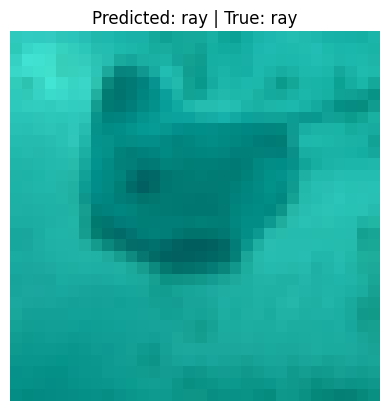

In [74]:
test_img, test_target = test_dataset[323]

model.eval()
with torch.no_grad():
    test_img = test_img.unsqueeze(0).to(device)
    test_pred = model(test_img)
    test_pred = F.softmax(test_pred, dim=1)

    test_pred = test_pred.cpu().numpy().squeeze()
    test_pred_label = np.argmax(test_pred)

    print(f"Predicted Label: {true_labels[test_pred_label]}")
    print(f"True Label: {true_labels[test_target]}")

    test_img = reverse_transform(test_img.squeeze(), train=False)
    plt.imshow(test_img)
    plt.title(
        f"Predicted: {true_labels[test_pred_label]} | True: {true_labels[test_target]}"
    )
    plt.axis("off")

    plt.show()


In [71]:
wandb.finish()

test_loss,▁
test_top1_acc,▁
test_top5_acc,▁
train_loss,█▇▆▆▅▅▄▄▃▃▃▂▂▂▁▁
val_loss,█▆▅▃▃▂▂▁▁▁▁▁▂▂▂
val_top1_acc,▁▂▃▄▅▆▆▇▇▇▇████
val_top5_acc,▁▃▄▅▆▆▇▇▇██████
test_loss,3.1419
test_top1_acc,0.305
test_top5_acc,0.6118
train_loss,1.53935


<IPython.core.display.HTML object>

<IPython.core.display.HTML object>